# SN Different Roll Periods
* Functional version of the signal to noise for a different point.
* Exploring the S/N for different windows. This uses the functional version of the sn for single point

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-darkgrid')
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib as mpl
from importlib import reload
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from enum import Enum
from dask.diagnostics import ProgressBar
import sys, matplotlib, os
# Contains path information
sys.path.append('../')

import constants
sys.path.append(constants.MODULE_DIR)

import signal_to_noise as sn
# Custom xarray classes that addes different method.
import xarray_class_accessors as xca

# Custom plots for signal to noise functions.
import sn_plotting as sn_plot

In [2]:
constants.LONGRUNMIP_DIR

'/g/data/w40/ab2313/PhD/longrunmip'

In [3]:
# The directory where all of the longrun mip data used in this notebook is stored.
# ROOT_DIR = '/g/data/w40/ab2313/longrunmip/'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR,'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped'

In [4]:
IMG_DIR = constants.IMAGE_SAVE_DIR_TOP_LEVEL
IMG_DIR

'/home/563/ab2313/gdata/images/PhD/top_level'

In [5]:
# The sample file being used in this notebook
fname = 'tas_ann_MPIESM11_abrupt4x_4459_g025'
model = 'MPIESM11'

# Loading Data
In this notebook everythning need to be run together to check the affect of having different roll period.s

In [6]:
path_control = os.path.join(ROOT_DIR, 'tas_mon_MPIESM12_control_1237_g025.nc')
path_control

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped/tas_mon_MPIESM12_control_1237_g025.nc'

In [7]:
control_chunks = {'lat':48/2,'lon':96/2,'time':-1}

In [8]:
# Opening the control data
control = xr.open_dataset(path_control,use_cftime = True, chunks = control_chunks).tas
control

<xarray.DataArray 'tas' (time: 1237, lat: 72, lon: 144)>
dask.array<open_dataset-4686c54e819cfde2cfd2cbeefc5ea40btas, shape=(1237, 72, 144), dtype=float32, chunksize=(1237, 24, 48), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1236-12-31 00:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75

In [9]:
# 4xCo2 data
path_abrupt4 = os.path.join(ROOT_DIR, 'tas_ann_MPIESM11_abrupt4x_4459_g025.nc')
path_abrupt4

'/g/data/w40/ab2313/PhD/longrunmip/regrid_retimestamped/tas_ann_MPIESM11_abrupt4x_4459_g025.nc'

In [10]:
abrupt = xr.open_dataset(path_abrupt4).tas
abrupt

<xarray.DataArray 'tas' (time: 4459, lat: 72, lon: 144)>
[46230912 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) object 0000-12-31 00:00:00 ... 4458-12-31 00:00:00
Attributes:
    long_name:  Near-Surface Air Temperature; usually on 2m
    units:      K
    code:       167
    table:      128

# Space Means

In [11]:
# The anomalies for the contorl.
control_anom = control.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1])

# THe global mean of the anomalies.
control_anom_smean = control_anom.clima.space_mean()
control_anom_smean

<xarray.DataArray 'tas' (time: 1237)>
dask.array<truediv, shape=(1237,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 1236-12-31 00:00:00

In [12]:
# Getting the temperature anomalies.
abrupt_anom = abrupt.clima.anomalies(start = control.time.dt.year.values[0], 
                                          end = control.time.dt.year.values[-1],
                            historical = control)

abrupt_anom_smean = abrupt_anom.clima.space_mean()
abrupt_anom_smean

Using historical dataset


<xarray.DataArray 'tas' (time: 4459)>
dask.array<truediv, shape=(4459,), dtype=float64, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-12-31 00:00:00 ... 4458-12-31 00:00:00

# Signal To Noise

In [13]:
reload(sn)
print(sn.global_mean_sn.__doc__)


    Calculates the signal to noise for an array da, based upon the control.
    
    A full guide on all the functions used here can be found at in 02_gmst_analysis.ipynb
    
    Parameters
    ----------
    da: xr.DataArray
        input array the the signal to noise is in question for 
    control: xr.DataArray
        the control to compare with
    da_loess: Optional[xr.DataArray]
        loess filtered da
    control_loess: Optional[xr.DataArray]
        loess filtered control
    window = 61: 
        the window length
    return_all = False
        see below (return either 4 datasets or 9)
    logginglevel = 'ERROR'
    
    
    Note: 
    Returns 4 datasets: da_sn, da_sn_stable, da_sn_increasing, da_sn_decreasing
    
    
    But can be changed to return 9 datasets with return_all = True: 
                da_stable, da_increasing, da_decreasing, 
                da_sn, da_sn_stable, da_sn_increasing, da_sn_decreasing, 
                control__lbound, control__ubound
    d

In [14]:
(da_stable, da_increasing, da_decreasing, da_sn, da_sn_stable, da_sn_increasing, da_sn_decreasing, 
                control_smean_lbound, control_smean_ubound) =\
     sn.global_mean_sn(abrupt_anom_smean, control_anom_smean, window = 61, return_all=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/array/core.py:1650: FutureWarning: The `numpy.nanpercentile` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [ ]:
da_increasing = da_increasing.compute()
da_stable = da_stable.compute()

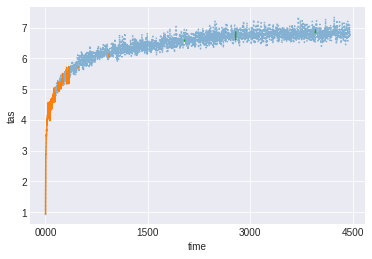

In [15]:
abrupt_anom_smean.plot(alpha = 0.5, linestyle=':')
da_increasing.plot()
da_decreasing.plot()

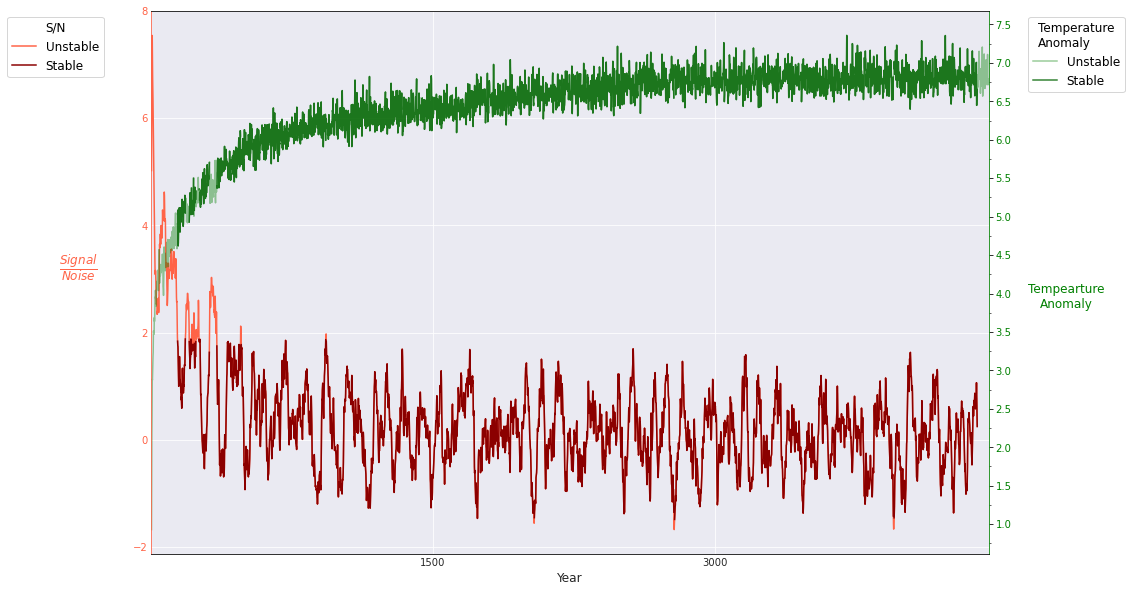

In [16]:
fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)

sn_plot.temperature_vs_sn_plot(ax,  da_sn, abrupt_anom_smean,
                      temp_highlight = da_stable, 
                      sn_highlight = da_sn_stable)


fig.savefig(f'{IMG_DIR}/03_{model}_global_sn_temp_anomaly.png', bbox_inches='tight', dpi=500)

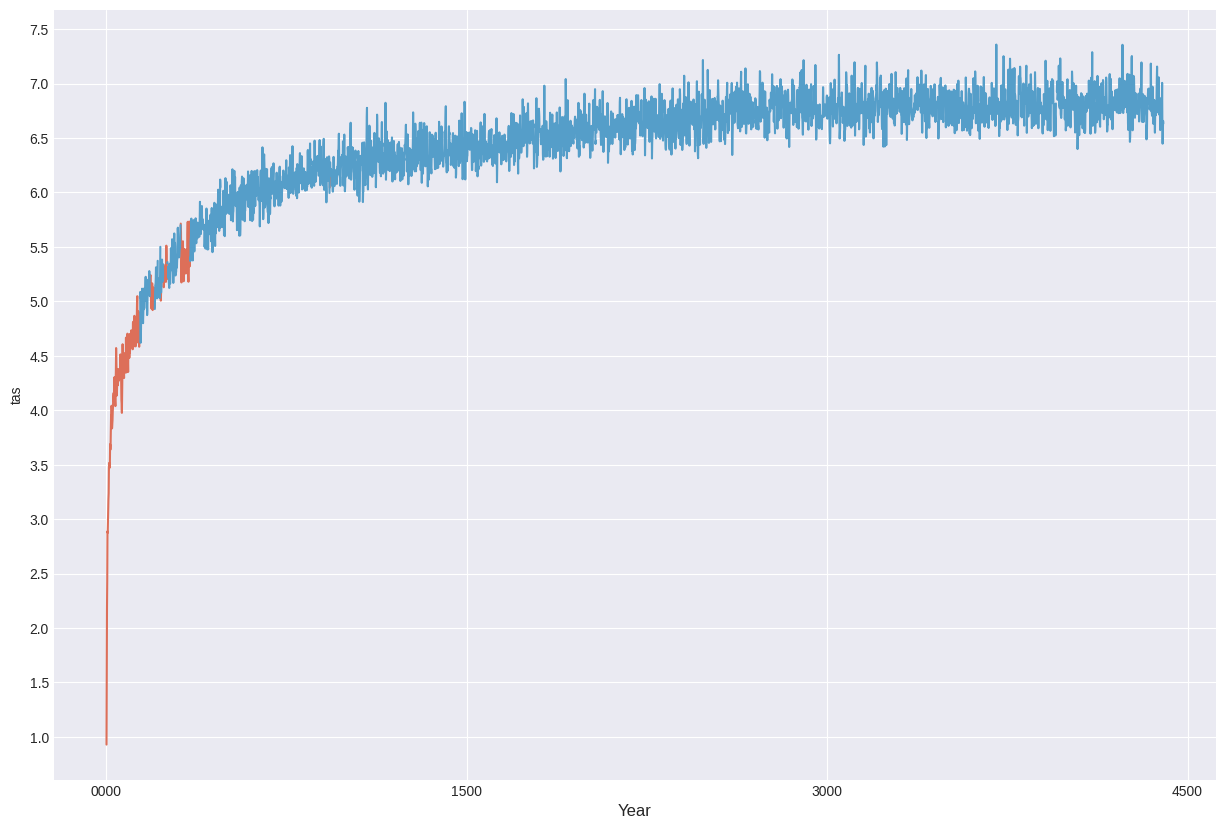

In [33]:

plt.style.use("seaborn-darkgrid")
cmap = mpl.cm.get_cmap('RdBu', 10)

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
da_increasing.plot(ax=ax, alpha=1, c=cmap(2))
da_stable.plot(ax=ax, c=cmap(7))

ax.yaxis.set_major_locator(mticker.MultipleLocator(.5))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(.25))


ax.set_xlabel('Year', fontsize = 12);
# ax.set_xlim(abrupt_anom_smean.time.values[0], abrupt_anom_smean.time.values[-1])


# Multi-window

We now want to test the effect of multiple-windows.

In [17]:
reload(sn)
print(sn.sn_multi_window.__doc__)


    Calls the global_mean_sn function repeatedly for windows ranging betweent start_window
    and end_window with a step size of step_window.
    
    Parameters
    ----------
    
    da, control_da, start_window = 21, end_window = 221, step_window = 8
    
    
    Returns
    -------
    unstable_sn_multi_window_da , stable_sn_multi_window_da  Both these data sets contian dimension of time and window.
    


In [18]:
# Computing these values before hand to speed up calculations
abrupt_anom_smean = abrupt_anom_smean.compute()
control_anom_smean = control_anom_smean.compute()

In [19]:
print(sn.sn_multi_window.__doc__)


    Calls the global_mean_sn function repeatedly for windows ranging betweent start_window
    and end_window with a step size of step_window.
    
    Parameters
    ----------
    
    da, control_da, start_window = 21, end_window = 221, step_window = 8
    
    
    Returns
    -------
    unstable_sn_multi_window_da , stable_sn_multi_window_da  Both these data sets contian dimension of time and window.
    


In [20]:
reload(sn)

<module 'signal_to_noise' from '/home/563/ab2313/Documents/PhD/modules/signal_to_noise.py'>

In [21]:
unstable_sn_multi_window_da , stable_sn_multi_window_da =\
                sn.sn_multi_window(abrupt_anom_smean,control_anom_smean, end_window=500, step_window=2)

Starting window loop from 21 to 500 with step size of 2
21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 383, 385, 387, 389, 391, 393, 395, 397, 399, 401, 403, 405, 407, 409, 411, 413,

In [22]:
unstable_sn_multi_window_da

<xarray.DataArray 'SN' (window: 240, time: 4439)>
array([[ 4.00161037,  4.54167087,  5.29744358, ...,         nan,
                nan,         nan],
       [ 4.11310512,  4.61941071,  5.36172896, ...,         nan,
                nan,         nan],
       [ 4.12069964,  4.67492685,  5.5101013 , ...,         nan,
                nan,         nan],
       ...,
       [11.20927063, 12.97316156, 14.29612451, ...,         nan,
                nan,         nan],
       [11.23026858, 13.00997756, 14.33744478, ...,         nan,
                nan,         nan],
       [11.2615053 , 13.05311046, 14.36657608, ...,         nan,
                nan,         nan]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 4432 4433 4434 4435 4436 4437 4438
  * window   (window) int64 21 23 25 27 29 31 33 ... 487 489 491 493 495 497 499

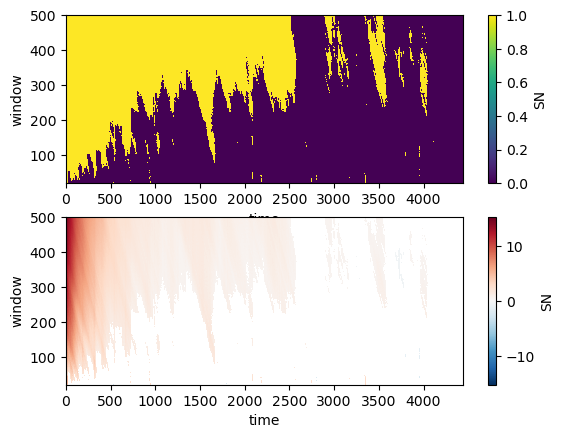

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1)
stable_sn_multi_window_da.plot(ax=ax1)
unstable_sn_multi_window_da.plot(ax=ax2)

{'height': 15, 'width': 7, 'hspace': 0.3, 'vmin': -8, 'vmax': 8, 'step': 1, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x7f2c0706a580>, 'line_color': 'limegreen', 'line_alpha': 0.5, 'cbar_label': 'S/N', 'cbartick_offset': 0, 'title': 'MPIESM11', 'label_size': 12, 'extend': 'both', 'xlowerlim': None, 'xupperlim': None, 'filter_max': False, 'levels': array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), 'cbar_xticklabels': array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), 'cbar_ticks': array([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8])}




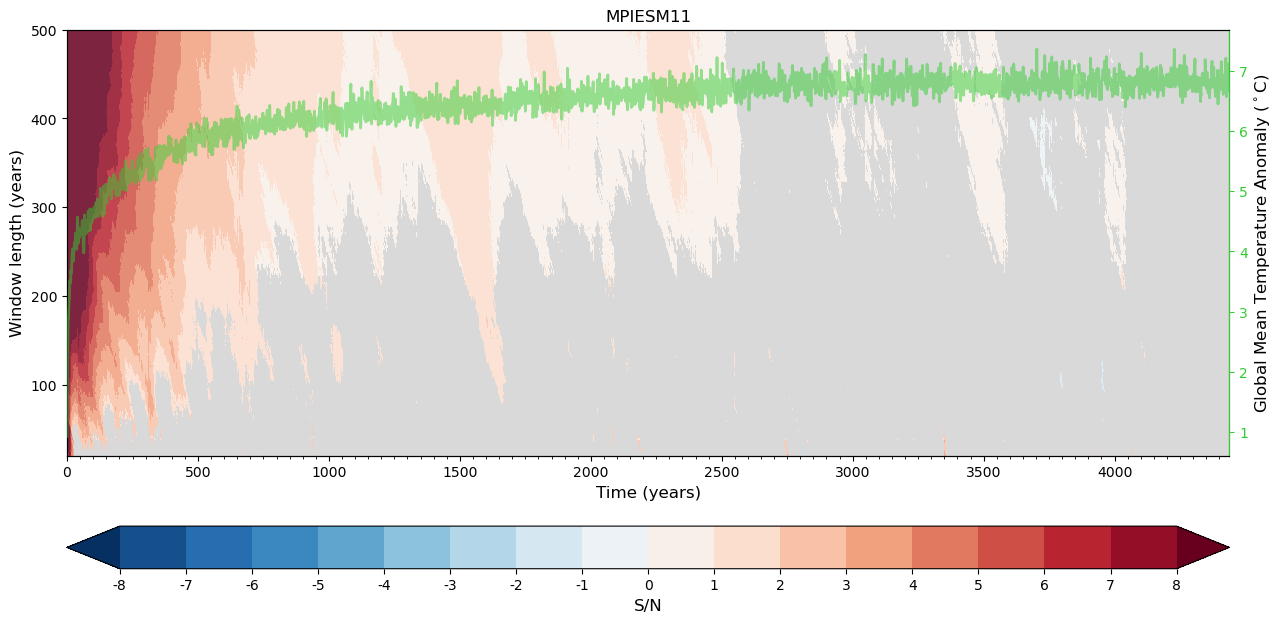

In [24]:
sn_plot.sn_multi_window_in_time(unstable_sn_multi_window_da, 
                            stable_sn_multi_window_da,
                            abrupt_anom_smean, title=model, step=1);
ax.set_xlim([0,4500])
fig.savefig(f'{IMG_DIR}/03_{model}_SN_multi_window_long_small_step.png', dpi=400, bbox_inches='tight')